In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from interaction_inference import dataset, correlation, optimization
import ensembl_rest as ens
import time
import json
import plotly
import plotly.graph_objects as go

# Coding - Non-coding Interactions

Given a dataset of transcript counts for each gene across a set of cells we want to test for interaction between pairs of transcripts / genes.

However, with such large datasets it is not practical to test all pairs and we should instead use prior information to select a good subset.

## RNA types

Using the gene name / symbol (or ensembl ID) we can use a database such as Ensembl to lookup information about the gene and its transcripts such as its type:

- protein coding
- lncRNA
- miRNA
- ...

In [7]:
data_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)
data_FIB.head()

,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P23_S383,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
7SK,18,3,6,8,35,0,0,21,9,9,...,61,23,19,5,0,3,23,15,1,14
A4GALT,0,0,0,0,0,0,0,0,0,28,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,0,0,0,0,0,3,4,...,0,0,0,0,705,0,5,0,0,0
AACS,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,4,55,22,42
AADAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,270,0,0,0,0,0


In [ ]:
'''
API limit of 15 lookups per second + slow response time => ~40 minute runtime
'''

# get all gene symbols / names
gene_symbols = list(data_FIB.index)

# use emsembl API to lookup each gene, recording type or failure
biotypes = []
failures = 0
for i, symbol in enumerate(gene_symbols):
    if i % 14 == 0:
        time.sleep(2)
    try:
        info = ens.symbol_lookup(
            species='homo sapiens',
            symbol=symbol
        )
        biotypes.append(info['biotype'])
    except ens.HTTPError:
        failures += 1
        biotypes.append("Failure")

# some gene symbols reset in HTTP error due to no matching record in database
print(f"{failures} failed lookups")

In [8]:
# read in from file
biotypes_dict = json.load(open("./Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

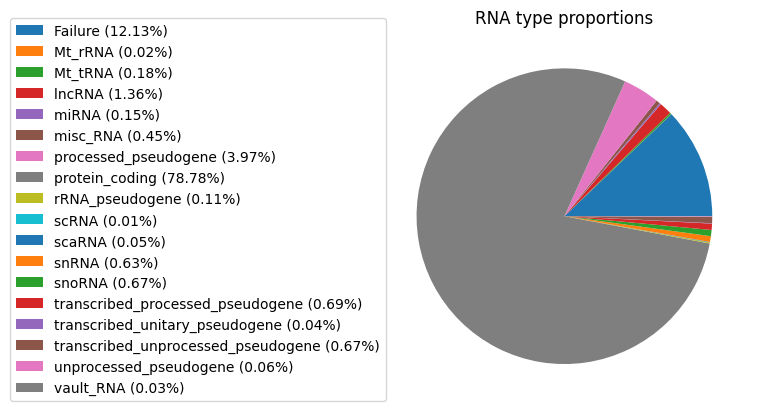

In [9]:
# display proportions of RNA types
counts = np.unique(biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / data_FIB.shape[0], 2)}%)" for name, count in zip(counts[0], counts[1])])
plt.title("RNA type proportions")
plt.show()

## Prior selection

To start with, we consider pairing 'protein coding' genes: which 'code' for proteins that are produced via transcription of RNA and then translation, with 'non-coding' genes: which do not 'code' for proteins but are suggested to play a crucial role in regulation of expression and other functions.

We take genes with 'protein_coding' RNA type (but very large number, so start with a subset to test), 'lncRNA' long non-coding RNA, and 'miRNA' micro RNA - small non-coding RNA.

In [10]:
# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
lncRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "lncRNA"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]
ncRNA_indices = [idx for idx, val in enumerate(biotypes) if not val == "protein_coding"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_lncRNA = data_FIB.iloc[lncRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]
data_ncRNA = data_FIB.iloc[ncRNA_indices]

print(f"{data_pcRNA.shape[0]} protein coding RNA \n{data_lncRNA.shape[0]} lncRNA \n{data_miRNA.shape[0]} miRNA")

9376 protein coding RNA 
162 lncRNA 
18 miRNA


## Capture efficiency estimation

To apply optimization methods we need an estimate of the capture efficiency present in the observations. This is done by normalizing the propotion of counts per cell (across all genes, relative to the counts over all cells and genes) to a set value e.g. 10% (with additional removal of outlying genes).

Also investigate how the estimates change when computed for e.g. all gene types vs just protein coding genes

In [7]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

In [8]:
def estimate_capture_naive(df, beta_mean=0.1):

    # total counts per cell
    total_per_cell = df.sum(axis='rows')

    # total counts across all cells
    total_overall = total_per_cell.sum()

    # count proportions per cell (sum = 1)
    count_proportion = (total_per_cell / total_overall).to_numpy()

    # number of cells
    n = count_proportion.size

    # re-normalize
    beta = count_proportion * beta_mean * n

    # clamp values outside [0, 1]
    if (beta >= 1).size > 0:
        beta[beta >= 1] = beta[beta < 1].max()
    if (beta <= 0).size > 0:
        beta[beta <= 0] = beta[beta > 0].min()

    return beta

In [9]:
beta_overall = estimate_capture(data_FIB)
beta_naive_overall = estimate_capture_naive(data_FIB)

In [10]:
beta_pcRNA= estimate_capture(data_pcRNA)
beta_naive_pcRNA = estimate_capture_naive(data_pcRNA)

In [11]:
beta_ncRNA= estimate_capture(data_ncRNA)
beta_naive_ncRNA = estimate_capture_naive(data_ncRNA)

Text(0.5, 1.0, 'Estimates of capture efficiency distributions')

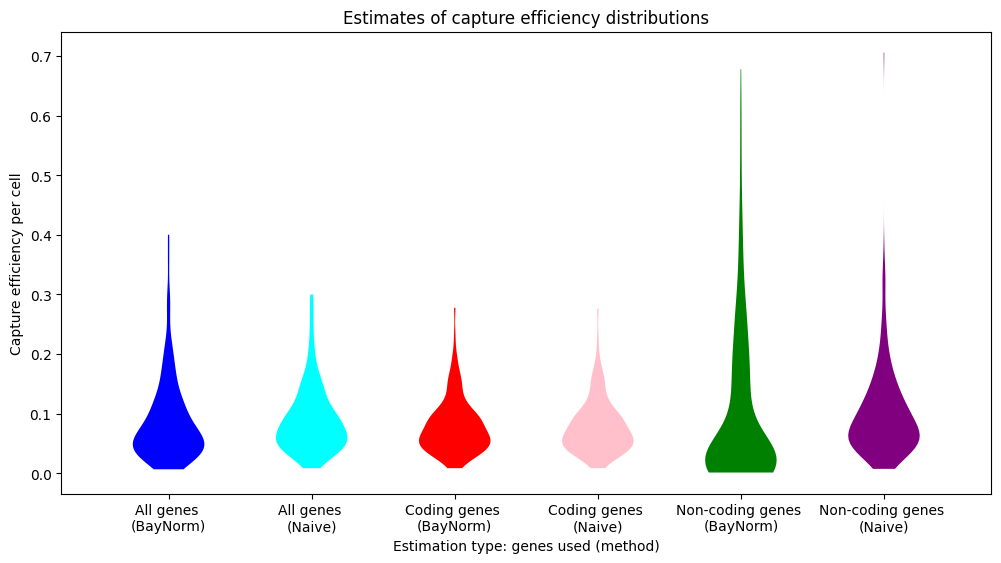

In [12]:
fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        beta_overall,
        beta_naive_overall,
        beta_pcRNA,
        beta_naive_pcRNA,
        beta_ncRNA,
        beta_naive_ncRNA
    ],
    showextrema=False
)
colours = ["blue", "cyan", "red", "pink", "green", "purple"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["All genes \n(BayNorm)", "All genes \n(Naive)", "Coding genes \n(BayNorm)", "Coding genes \n(Naive)", "Non-coding genes \n(BayNorm)", "Non-coding genes \n(Naive)"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Estimation type: genes used (method)')
axs.set_ylabel("Capture efficiency per cell")
axs.set_title("Estimates of capture efficiency distributions")

# Independent gene analysis

For each gene we can test if the observed data is feasible under an independent model e.g. birth-death, telegraph, etc.

This gives information both about the presence of interaction and the types of models that can explain expression.

## Analysis

The inference package is designed to work with paired data, so we construct a dataset object of 'pairs' by pairing each gene with zero values

In [13]:
def construct_independent_dataset(name, df, beta, thresh_OB=5, resamples=1000):
    '''
    Construct dataset object from a dataframe. Each 'pair' is a row of the dataframe
    paired with zeros to allow for independent feasibility tests.

    name: dataset name
    df: pandas dataframe of transcript counts
    beta: estimated capture efficiency
    thresh_OB: dataset bootstrap threshold
    resamples: dataset bootstrap resamples
    '''

    # size
    gene_pairs, cells = df.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = df.iloc[i]
        gene_j = [0 for i in range(cells)]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = dataset.Dataset(name)
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.thresh_OB = thresh_OB
    data.threshM_OB = thresh_OB
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

### Protein Coding RNA (subset)

In [14]:
# select a subset of protein coding genes
data_pcRNA_subset = data_pcRNA.iloc[0:100, :]

In [15]:
dataset_pcRNA = construct_independent_dataset("pcRNA", data_pcRNA_subset, beta_overall)

In [16]:
dataset_pcRNA.bootstrap_marginal_fm(tqdm_disable=False)

 10%|█         | 10/100 [00:00<00:00, 98.37it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 31%|███       | 31/100 [00:00<00:00, 83.48it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 50%|█████     | 50/100 [00:00<00:00, 80.37it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 59%|█████▉    | 59/100 [00:00<00:00, 77.20it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 76%|███████▌  | 76/100 [00:00<00:00, 75.70it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


100%|██████████| 100/100 [00:01<00:00, 83.13it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


In [19]:
dataset_pcRNA.bootstrap_marginal_probabilities(tqdm_disable=False)

  6%|▌         | 6/100 [00:00<00:01, 59.00it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 20%|██        | 20/100 [00:00<00:01, 55.96it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 27%|██▋       | 27/100 [00:00<00:01, 53.93it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 39%|███▉      | 39/100 [00:00<00:01, 53.73it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 54%|█████▍    | 54/100 [00:00<00:00, 57.88it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 67%|██████▋   | 67/100 [00:01<00:00, 58.39it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 74%|███████▍  | 74/100 [00:01<00:00, 59.69it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 86%|████████▌ | 86/100 [00:01<00:00, 46.49it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


100%|██████████| 100/100 [00:01<00:00, 54.18it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


In [20]:
# birth death feasibility test
optimization_pcRNA_BD = optimization.Optimization(
    dataset_pcRNA,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

 93%|█████████▎| 93/100 [00:13<00:02,  2.50it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 134, in add_variables
    variables['pd1'] = model.addMVar(shape=(optimization.dataset.truncationM_OB[f'sample-{i}']['maxM_x1_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd1", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset


Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


In [21]:
# telegraph feasibility test
optimization_pcRNA_TE = optimization.Optimization(
    dataset_pcRNA,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_TE_1",
        "downsampled_marginal_TE_link_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

 96%|█████████▌| 96/100 [00:14<00:00,  9.85it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 134, in add_variables
    variables['pd1'] = model.addMVar(shape=(optimization.dataset.truncationM_OB[f'sample-{i}']['maxM_x1_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd1", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset


Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


### lncRNA

In [22]:
dataset_lncRNA = construct_independent_dataset("lncRNA", data_lncRNA, beta_overall)

In [23]:
dataset_lncRNA.bootstrap_marginal_fm(tqdm_disable=False)

  6%|▌         | 10/162 [00:00<00:01, 93.83it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to

 20%|██        | 33/162 [00:00<00:01, 87.86it/s] 

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 26%|██▌       | 42/162 [00:00<00:01, 86.73it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 38%|███▊      | 61/162 [00:00<00:01, 75.43it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 43%|████▎     | 69/162 [00:00<00:01, 65.41it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 51%|█████     | 83/162 [00:01<00:01, 56.59it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 55%|█████▍    | 89/162 [00:01<00:01, 55.13it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 65%|██████▌   | 106/162 [00:01<00:00, 60.25it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 76%|███████▌  | 123/162 [00:01<00:00, 69.80it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to

 83%|████████▎ | 134/162 [00:01<00:00, 77.78it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 92%|█████████▏| 149/162 [00:02<00:00, 55.99it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


100%|██████████| 162/162 [00:02<00:00, 67.23it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


In [24]:
dataset_lncRNA.bootstrap_marginal_probabilities(tqdm_disable=False)

  5%|▍         | 8/162 [00:00<00:02, 75.92it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 15%|█▍        | 24/162 [00:00<00:02, 60.71it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 19%|█▉        | 31/162 [00:00<00:02, 60.11it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 28%|██▊       | 45/162 [00:00<00:02, 57.29it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 37%|███▋      | 60/162 [00:01<00:01, 57.47it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 41%|████      | 66/162 [00:01<00:01, 57.02it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 48%|████▊     | 78/162 [00:01<00:01, 48.24it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 59%|█████▊    | 95/162 [00:01<00:01, 63.15it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 69%|██████▊   | 111/162 [00:01<00:00, 69.03it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 78%|███████▊  | 126/162 [00:02<00:00, 64.93it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 82%|████████▏ | 133/162 [00:02<00:00, 60.74it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 92%|█████████▏| 149/162 [00:02<00:00, 64.73it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


 96%|█████████▋| 156/162 [00:02<00:00, 56.16it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


100%|██████████| 162/162 [00:02<00:00, 58.60it/s]

Truncation extended from [0, 0] to [0, 1]


In [25]:
# birth death feasibility test
optimization_lncRNA_BD = optimization.Optimization(
    dataset_lncRNA,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

 42%|████▏     | 68/162 [05:03<01:16,  1.23it/s]  Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 134, in add_variables
    variables['pd1'] = model.addMVar(shape=(optimization.dataset.truncationM_OB[f'sample-{i}']['maxM_x1_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd1", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
 44%|████▍     | 72/162 [05:03<00:54,  1.65it/s]

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


100%|██████████| 162/162 [10:22<00:00,  3.84s/it]


In [26]:
# telegraph feasibility test
optimization_lncRNA_TE = optimization.Optimization(
    dataset_lncRNA,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_TE_1",
        "downsampled_marginal_TE_link_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

 42%|████▏     | 68/162 [00:08<00:05, 16.67it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 134, in add_variables
    variables['pd1'] = model.addMVar(shape=(optimization.dataset.truncationM_OB[f'sample-{i}']['maxM_x1_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd1", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
 44%|████▍     | 71/162 [00:08<00:04, 18.85it/s]

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


100%|██████████| 162/162 [00:18<00:00,  8.80it/s]


### miRNA

In [27]:
dataset_miRNA = construct_independent_dataset("miRNA", data_miRNA, beta_overall)

In [28]:
dataset_miRNA.bootstrap_marginal_fm(tqdm_disable=False)

100%|██████████| 18/18 [00:00<00:00, 111.25it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


In [29]:
dataset_miRNA.bootstrap_marginal_probabilities(tqdm_disable=False)

 39%|███▉      | 7/18 [00:00<00:00, 66.79it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


100%|██████████| 18/18 [00:00<00:00, 76.50it/s]

Truncation extended from [0, 0] to [0, 1]
Truncation extended from [0, 0] to [0, 1]


In [31]:
# birth death feasibility test
optimization_miRNA_BD = optimization.Optimization(
    dataset_miRNA,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 18/18 [00:00<00:00, 28.54it/s]


In [32]:
# telegraph feasibility test
optimization_miRNA_TE = optimization.Optimization(
    dataset_miRNA,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_TE_1",
        "downsampled_marginal_TE_link_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 18/18 [00:01<00:00, 17.24it/s]


### Optimization time

In [33]:
times_BD = []
times_TE = []
times_BD += [res['time'] for res in optimization_pcRNA_BD.result_dict.values()]
times_BD += [res['time'] for res in optimization_lncRNA_BD.result_dict.values()]
times_BD += [res['time'] for res in optimization_miRNA_BD.result_dict.values()]
times_TE += [res['time'] for res in optimization_pcRNA_TE.result_dict.values()]
times_TE += [res['time'] for res in optimization_lncRNA_TE.result_dict.values()]
times_TE += [res['time'] for res in optimization_miRNA_TE.result_dict.values()]

Text(0.5, 1.0, 'Distribution of optimization time')

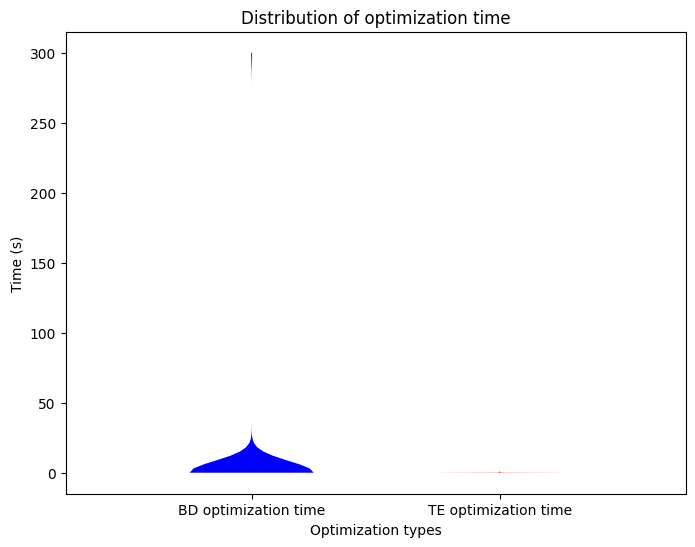

In [34]:
fig, axs = plt.subplots(figsize=(8, 6))
vp = axs.violinplot(
    [
        times_BD,
        times_TE
    ],
    showextrema=False
)
colours = ["blue", "red"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["BD optimization time", "TE optimization time"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Optimization types')
axs.set_ylabel("Time (s)")
axs.set_title("Distribution of optimization time")

Text(0.5, 1.0, 'Distribution of optimization time')

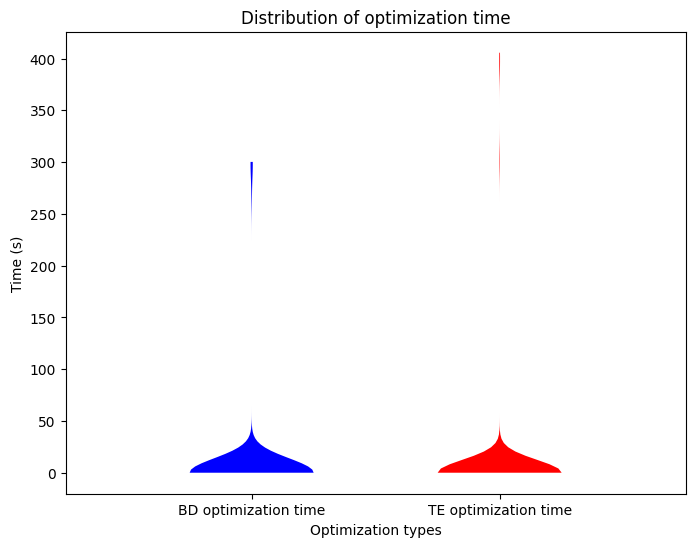

In [ ]:
# old truncation code times

## Plots

In [3]:
def sankey_from_df(df, title):

    column_number = df.shape[1]

    # unique values per column
    column_values = []

    # box indices per column
    column_indices = []

    i = 1
    for col in df.columns:

        values = df[col].unique().tolist()
        column_values.append(values)

        boxes = len(values)
        indices = [x for x in range(i, i + boxes)]
        column_indices.append(indices)

        i += boxes

    # plotting
    source = []
    target = []
    count = []

    # special case for first gap

    # end values
    val_end = column_values[0]

    # end indices
    idx_end = column_indices[0]

    # end column
    col_end = df[df.columns[0]]

    # for each end value
    for val_k, idx_k in zip(val_end, idx_end):

        # get count
        count_k = len(df.loc[col_end == val_k])

        # add link to plot: from 0 to idx with size count
        source.append(0)
        target.append(idx_k)
        count.append(count_k)

    for i in range(column_number - 1):

        # get values
        val_start = column_values[i]
        val_end = column_values[i + 1]

        # get indices
        idx_start = column_indices[i]
        idx_end = column_indices[i + 1]

        # get columns
        col_start = df[df.columns[i]]
        col_end = df[df.columns[i + 1]]

        # for each pair of values level
        for val_j, idx_j in zip(val_start, idx_start):
            for val_k, idx_k in zip(val_end, idx_end):

                # get overlap
                count_jk = len(df.loc[(col_start == val_j) & (col_end == val_k)])

                # add link to plot: from idx_j to idx_k with size count_jk
                source.append(idx_j)
                target.append(idx_k)
                count.append(count_jk)

    # box labels
    labels = [""]
    for values in column_values:
        for val in values:
            labels.append(str(val))

    fig = go.Figure(data=[go.Sankey(
        node = {"label": labels},
        link = {"source": source, "target": target, "value": count, "color": "lightgrey"}
        )])

    headers = ["Genes"] + list(df.columns)
    for x_coordinate, column_name in enumerate(headers):
        fig.add_annotation(
                x=x_coordinate / (column_number),
                y=1.1,
                xref="paper",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="tomato"
                    ),
                align="center",
                )
        
    #fig.update_layout(font_size=15)
    fig.update_layout(
        title_text=title, 
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }, plot_bgcolor='rgba(0,0,0,0)', font_size=10
    )

    fig.show()

In [36]:
def result_df(optim_BD, optim_TE):
    independent_feasibility = pd.DataFrame(columns=["Birth-Death", "Telegraph"])
    independent_feasibility["Birth-Death"] = [res['status'] for res in optim_BD.result_dict.values()]
    independent_feasibility["Telegraph"] = [res['status'] for res in optim_TE.result_dict.values()]
    return independent_feasibility

In [37]:
sankey_from_df(result_df(optimization_lncRNA_BD, optimization_lncRNA_TE), "lncRNA: Independent feasibility tests")

In [38]:
sankey_from_df(result_df(optimization_miRNA_BD, optimization_miRNA_TE), "miRNA: Independent feasibility tests")

In [39]:
sankey_from_df(result_df(optimization_pcRNA_BD, optimization_pcRNA_TE), "Protein Coding RNA: Independent feasibility tests")

# Interacting pair analysis

For each coding - non-coding gene pair we can use a variety of methods to test for interaction or model feasibility

## Analysis

Construct dataset objects with coding and non-coding genes paired

In [40]:
def construct_paired_dataset(name, pc_df, nc_df, beta, thresh_OB=5, resamples=1000):
    '''
    Construct dataset object from coding and non-coding dataframes containing
    all pairs of coding and non-coding genes to allow correlation or moment 
    and interacting feasibility tests.

    name: dataset name
    pc_df: pandas dataframe of protein coding transcript counts
    nc_df: pandas dataframe of no-coding transcript counts
    beta: estimated capture efficiency
    thresh_OB: dataset bootstrap threshold
    resamples: dataset bootstrap resamples
    '''

    # size
    pc_genes = pc_df.shape[0]
    nc_genes = nc_df.shape[0]
    gene_pairs = pc_genes * nc_genes
    cells = pc_df.shape[1]

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    k = 0
    for i in range(pc_genes):
        for j in range(nc_genes):
            gene_i = pc_df.iloc[i]
            gene_j = nc_df.iloc[j]
            gene_pair_ij = list(zip(gene_i, gene_j))
            counts_df.iloc[k] = gene_pair_ij
            k += 1

    # construct dataset object
    data = dataset.Dataset(name)
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.thresh_OB = thresh_OB
    data.threshM_OB = thresh_OB
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

### Protein Coding RNA (subset) - lncRNA

In [41]:
# select a subset of protein coding genes
data_pcRNA_subset = data_pcRNA.iloc[0:100, :]

In [42]:
dataset_pcRNA_lncRNA = construct_paired_dataset("pcRNA_lncRNA", data_pcRNA_subset, data_lncRNA, beta_overall)

In [43]:
correlation_pcRNA_lncRNA = correlation.Correlation(dataset_pcRNA_lncRNA, printing=False)

100%|██████████| 16200/16200 [00:25<00:00, 626.14it/s]


In [45]:
dataset_pcRNA_lncRNA.compute_moments(tqdm_disable=False)

100%|██████████| 16200/16200 [04:49<00:00, 55.99it/s]


In [46]:
# moment optimization test
moment_pcRNA_lncRNA = optimization.Optimization(
    dataset_pcRNA_lncRNA,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 16200/16200 [05:01<00:00, 53.69it/s]


### Protein Coding RNA (subset) - miRNA

In [47]:
# select a subset of protein coding genes
data_pcRNA_subset = data_pcRNA.iloc[0:100, :]

In [48]:
dataset_pcRNA_miRNA = construct_paired_dataset("pcRNA_miRNA", data_pcRNA_subset, data_miRNA, beta_overall)

In [49]:
correlation_pcRNA_miRNA = correlation.Correlation(dataset_pcRNA_miRNA, printing=False)

100%|██████████| 1800/1800 [00:02<00:00, 810.87it/s]


In [50]:
dataset_pcRNA_miRNA.compute_moments(tqdm_disable=False)

100%|██████████| 1800/1800 [00:37<00:00, 48.43it/s]


In [51]:
# moment optimization test
moment_pcRNA_miRNA = optimization.Optimization(
    dataset_pcRNA_miRNA,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 1800/1800 [00:34<00:00, 52.03it/s]


In [52]:
# settings
dataset_pcRNA_miRNA.splits = 10

In [53]:
dataset_pcRNA_miRNA.bootstrap_joint_fm(tqdm_disable=False)

100%|██████████| 1800/1800 [00:19<00:00, 90.17it/s] 


In [54]:
dataset_pcRNA_miRNA.bootstrap_joint_probabilities(tqdm_disable=False)

100%|██████████| 1800/1800 [03:06<00:00,  9.64it/s]


In [55]:
# interacting birth death feasibility test
optimization_pcRNA_miRNA_int_BD = optimization.Optimization(
    dataset_pcRNA_miRNA,
    [
        "downsampled_probability",
        "downsampled_CME",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

 28%|██▊       | 510/1800 [21:28<16:46,  1.28it/s]   Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'


Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 29%|██▊       | 517/1800 [21:29<07:02,  3.04it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'


Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 50%|█████     | 906/1800 [52:54<01:42,  8.71it/s]   Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
 51%|█████     | 910/1800 [52:54<01:17, 11.55it/s]

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 75%|███████▌  | 1356/1800 [1:21:04<01:12,  6.16it/s]   Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'


Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 86%|████████▋ | 1553/1800 [1:31:28<04:44,  1.15s/it]  Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
 86%|████████▋ | 1555/1800 [1:31:28<03:33,  1.15it/s]

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 87%|████████▋ | 1561/1800 [1:31:29<01:36,  2.47it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
 87%|████████▋ | 1563/1800 [1:31:29<01:14,  3.20it/s]

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 91%|█████████▏| 1644/1800 [1:37:08<02:29,  1.04it/s]  Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
 92%|█████████▏| 1647/1800 [1:37:08<01:34,  1.63it/s]

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 92%|█████████▏| 1651/1800 [1:37:09<01:03,  2.35it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
 92%|█████████▏| 1653/1800 [1:37:09<00:47,  3.07it/s]

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 96%|█████████▌| 1728/1800 [1:37:14<00:02, 24.97it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in 

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in 

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in 

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in 

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


 99%|█████████▉| 1787/1800 [1:42:18<00:21,  1.67s/it]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
 99%|█████████▉| 1789/1800 [1:42:19<00:12,  1.12s/it]Traceback (most recent call last):
  File "c:\Users\wi

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
100%|█████████▉| 1795/1800 [1:42:19<00:02,  2.19it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'
Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


100%|█████████▉| 1799/1800 [1:42:19<00:00,  3.44it/s]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 130, in optimize
    variables = constraints.add_variables(self, model, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 140, in add_variables
    variables['pd'] = model.addMVar(shape=(optimization.dataset.truncation_OB[f'sample-{i}']['max_x1_OB'] + 1, optimization.dataset.truncation_OB[f'sample-{i}']['max_x2_OB'] + 1), vtype=GRB.CONTINUOUS, name="pd", lb=0, ub=1)
TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'
100%|██████████| 1800/1800 [1:42:19<00:00,  3.41s/it]

Optimization failed: unsupported operand type(s) for +: 'NoneType' and 'int'


## Plots

In [56]:
def moment_gridplot(moment, pc_df, nc_df, title, pc_name, nc_name, figsize=(6, 6)):

    # size
    pc_genes = pc_df.shape[0]
    nc_genes = nc_df.shape[0]

    # construct array
    moment_array = np.empty((pc_genes, nc_genes))
    k = 0
    for i in range(pc_genes):
        for j in range(nc_genes):
            if moment.result_dict[k]['status'] == "INFEASIBLE":
                moment_array[i, j] = 1
            elif moment.result_dict[k]['status'] == "OPTIMAL":
                moment_array[i, j] = 0
            else:
                moment_array[i, j] = 0.5
            k += 1

    # plot
    fig, axs = plt.subplots(figsize=figsize)
    cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "w"), (1, "r")], N=256)
    vmin, vmax = 0, 1
    img = axs.imshow(moment_array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_title(title)
    axs.set_xlabel(nc_name)
    axs.set_ylabel(pc_name)
    #plt.axis('off')
    plt.text(0.0, 120.0, "Moment feasibility test for independence\
            \nBlue: feasible, independent pair \
            \nRed: infeasible, interacting pair \
            \nWhite: optimization failure")
    #cbar = plt.colorbar(img, ax=axs)
    #cbar.set_label("p-value")

In [57]:
def prob_gridplot(prob, pc_df, nc_df, title, pc_name, nc_name, figsize=(6, 6)):

    # size
    pc_genes = pc_df.shape[0]
    nc_genes = nc_df.shape[0]

    # construct array
    prob_array = np.empty((pc_genes, nc_genes))
    k = 0
    for i in range(pc_genes):
        for j in range(nc_genes):
            if prob.result_dict[k]['status'] == "INFEASIBLE":
                prob_array[i, j] = 1
            elif prob.result_dict[k]['status'] == "OPTIMAL":
                prob_array[i, j] = 0
            else:
                prob_array[i, j] = 0.5
            k += 1

    # plot
    fig, axs = plt.subplots(figsize=figsize)
    cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "w"), (1, "r")], N=256)
    vmin, vmax = 0, 1
    img = axs.imshow(prob_array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_title(title)
    axs.set_xlabel(nc_name)
    axs.set_ylabel(pc_name)
    #plt.axis('off')
    plt.text(0.0, 120.0, "Interacting Birth-Death feasibility test\
            \nBlue: feasible \
            \nRed: infeasible \
            \nWhite: optimization failure")
    #cbar = plt.colorbar(img, ax=axs)
    #cbar.set_label("p-value")

In [58]:
def correlation_gridplot(correlation, pc_df, nc_df, title, pc_name, nc_name, sig=0.05, figsize=(6, 6)):

    # size
    pc_genes = pc_df.shape[0]
    nc_genes = nc_df.shape[0]

    # construct array
    stat_array = np.empty((pc_genes, nc_genes))
    pvalue_array = np.empty((pc_genes, nc_genes))
    k = 0
    for i in range(pc_genes):
        for j in range(nc_genes):
            stat_array[i, j] = correlation.result_dict[k]['statistic']
            pvalue_array[i, j] = correlation.result_dict[k]['pvalue']
            k += 1

    # plot
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    eps = 10**-6
    cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (sig - eps, "r"), (sig + eps, "b"), (1, "b")], N=256)
    vmin, vmax = 0, 1
    img = axs[0].imshow(pvalue_array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_title("Pairwise gene correlation p-value (r < 0)")
    #plt.axis('off')
    axs[0].set_xlabel(nc_name)
    axs[0].set_ylabel(pc_name)
    cbar = plt.colorbar(img, ax=axs[0])
    cbar.set_label("p-value")

    cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (0.5, "w"), (1, "b")], N=256)
    vmin, vmax = -1, 1 #MAP_stat_array.min(), MAP_stat_array.max()
    img = axs[1].imshow(stat_array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_title("Pairwise gene correlations")
    #plt.axis('off')
    axs[1].set_xlabel(nc_name)
    axs[1].set_ylabel(pc_name)
    cbar = plt.colorbar(img, ax=axs[1])
    cbar.set_label("statistic")

In [70]:
def result_df(corr, momt):
    res = pd.DataFrame(columns=["Correlation test", "Moment test"])
    res["Correlation test"] = ["Interacting" if res['pvalue'] < 0.05 else "Independent" for res in corr.result_dict.values()]
    res["Moment test"] = ["Interacting" if res['status'] == "INFEASIBLE" else "Independent" for res in momt.result_dict.values()]
    return res

### Gridplots: correlation & moment

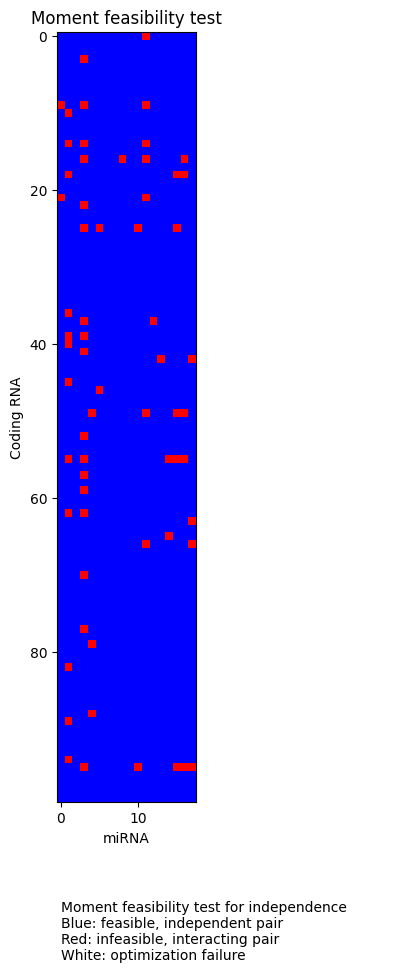

In [60]:
moment_gridplot(moment_pcRNA_miRNA, data_pcRNA_subset, data_miRNA, "Moment feasibility test", "Coding RNA", "miRNA", figsize=(10, 10))

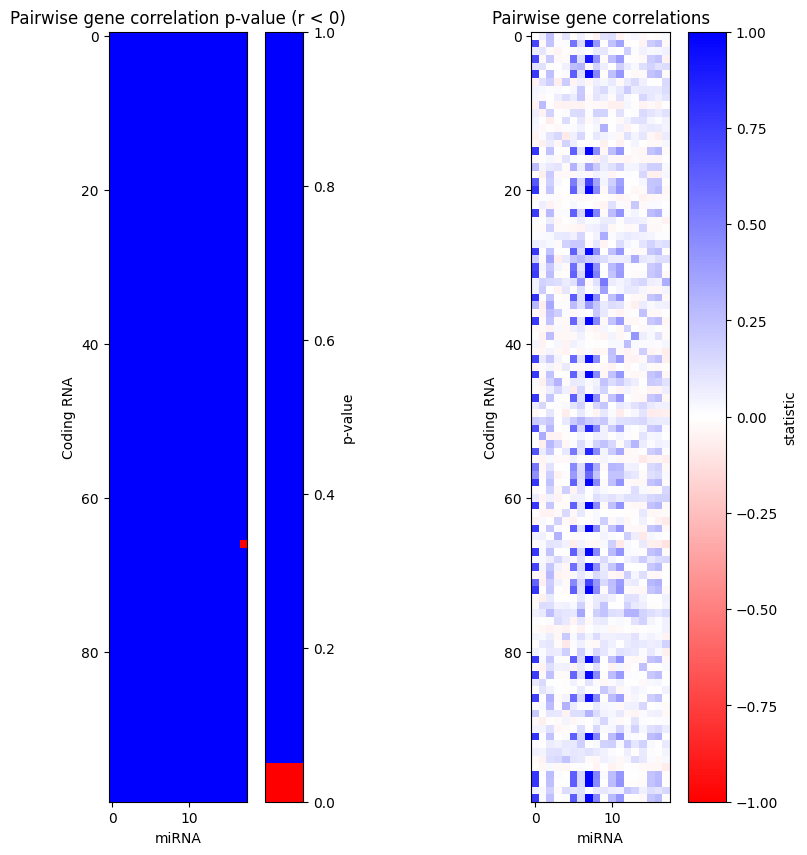

In [61]:
correlation_gridplot(correlation_pcRNA_miRNA, data_pcRNA_subset, data_miRNA, "Correlation test", "Coding RNA", "miRNA", figsize=(10, 10))

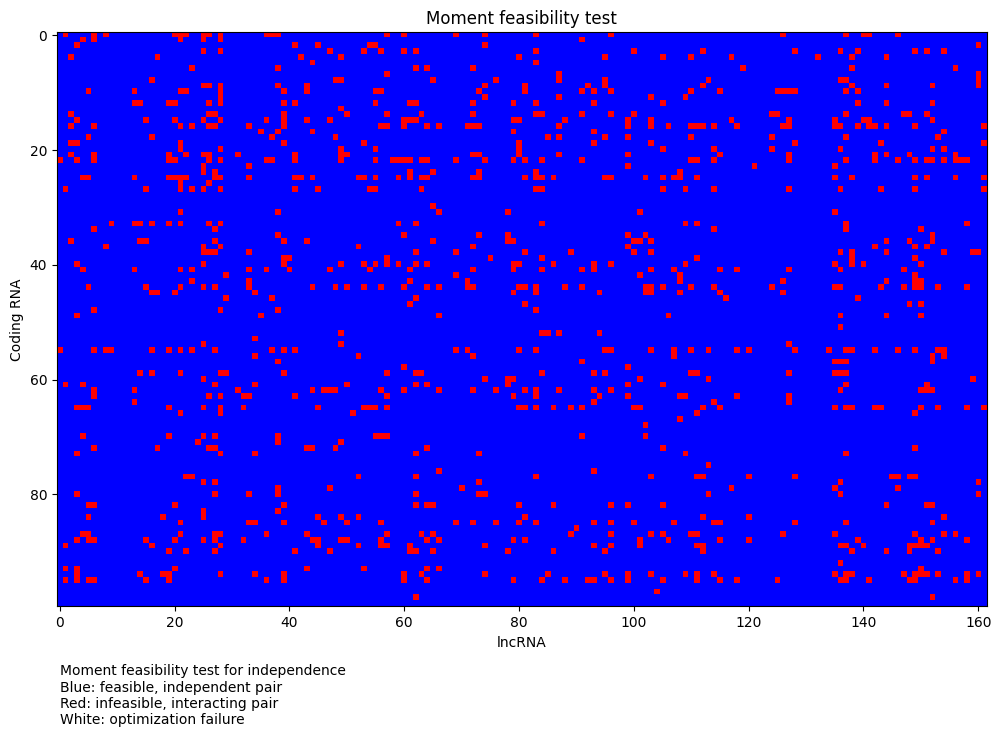

In [62]:
moment_gridplot(moment_pcRNA_lncRNA, data_pcRNA_subset, data_lncRNA, "Moment feasibility test", "Coding RNA", "lncRNA", figsize=(12, 10))

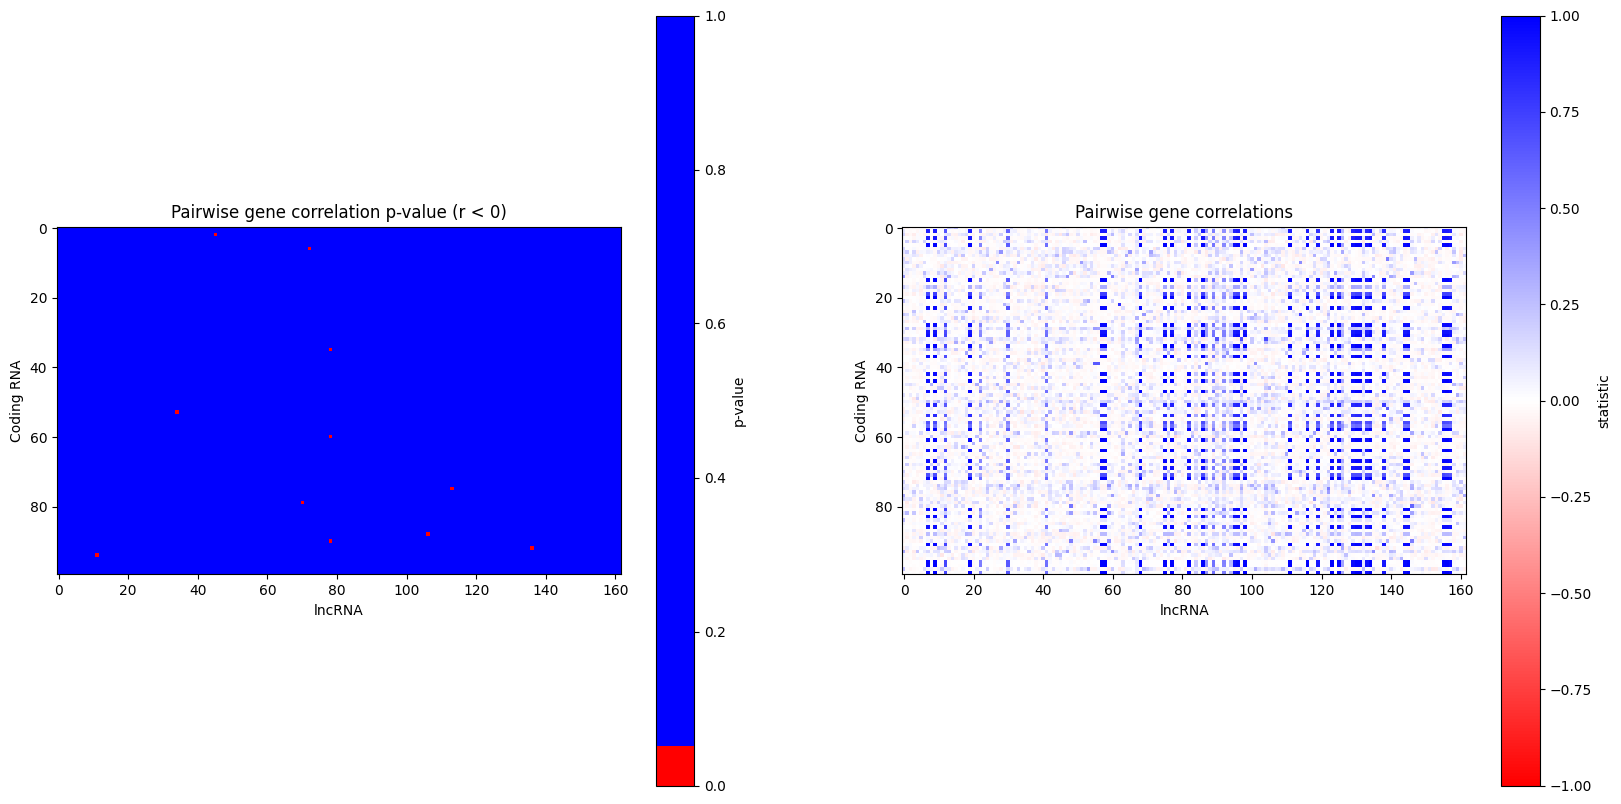

In [63]:
correlation_gridplot(correlation_pcRNA_lncRNA, data_pcRNA_subset, data_lncRNA, "Correlation test", "Coding RNA", "lncRNA", figsize=(20, 10))

### Gridplots: interacting model feasibility

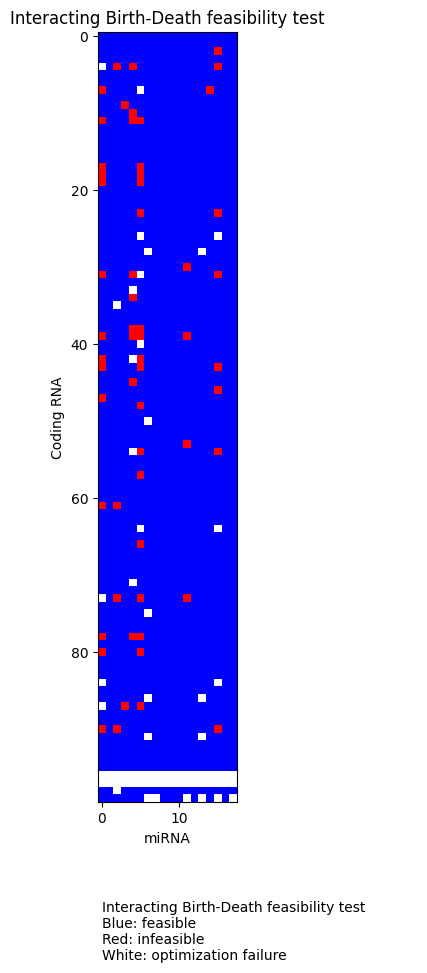

In [66]:
prob_gridplot(optimization_pcRNA_miRNA_int_BD, data_pcRNA_subset, data_miRNA, "Interacting Birth-Death feasibility test", "Coding RNA", "miRNA", figsize=(10, 10))

### Sankey: moment & interacting model tests

In [69]:
def result_df_prob(prob, momt):
    res = pd.DataFrame(columns=["Interacting Birth-Death", "Moment test"])
    res["Interacting Birth-Death"] = [res['status'] for res in prob.result_dict.values()]
    res["Moment test"] = [res['status'] for res in momt.result_dict.values()]
    return res

In [71]:
sankey_from_df(result_df_prob(optimization_pcRNA_miRNA_int_BD, moment_pcRNA_miRNA), "Coding RNA - miRNA: interacting birth-death & moment tests")

### Sankey: correlation & moment tests

In [64]:
sankey_from_df(result_df(correlation_pcRNA_miRNA, moment_pcRNA_miRNA), "Coding RNA - miRNA: correlation & moment tests")

In [65]:
sankey_from_df(result_df(correlation_pcRNA_lncRNA, moment_pcRNA_lncRNA), "Coding RNA - lncRNA: correlation & moment tests")

# Birth-Death model feasibility sankey

In [1]:
def result_df(int_BD_pc_nc, ind_BD_pc, ind_BD_nc):

    # size
    pc_genes = len(ind_BD_pc.result_dict)
    nc_genes = len(ind_BD_nc.result_dict)

    # construct df
    df = pd.DataFrame(columns=["Independent Birth-Death", "Interacting Birth-Death"])

    # get data
    ind_BD_list = []
    for i in range(pc_genes):
        gene_i = ind_BD_pc.result_dict[i]['status']
        for j in range(nc_genes):
            gene_j = ind_BD_nc.result_dict[j]['status']
            if gene_i < gene_j:
                ind_BD_list.append(gene_i + " - " + gene_j)
            else:
                ind_BD_list.append(gene_j + " - " + gene_i)
            '''
            if gene_i == "INFEASIBLE" and gene_j == "INFEASIBLE":
                BD_list.append('INF-INF')
            elif gene_i == "INFESIBLE" and gene_j == "OPTIMAL":
                BD_list.append('INF-OPT')
            elif gene_i == "OPTIMAL" and gene_j == "INFEASIBLE":
                BD_list.append('INF-OPT')
            elif gene_i == "OPTIMAL" and gene_j == "OPTIMAL":
                BD_list.append('OPT-OPT')
            else:
                BD_list.append('OTHER')
            '''

    # fill
    df["Independent Birth-Death"] = ind_BD_list
    df["Interacting Birth-Death"] = [res['status'] for res in int_BD_pc_nc.result_dict.values()]

    return df

In [4]:
sankey_from_df(result_df(optimization_pcRNA_miRNA_int_BD, optimization_pcRNA_BD, optimization_miRNA_BD), "Coding RNA - miRNA: birth death feasibility")

NameError: name 'optimization_pcRNA_miRNA_int_BD' is not defined

# Independent - Interacting result comparison

Compare how the independent birth-death model feasibility test results compare to the independent moment test

- are the genes that are infeasible under an independent BD model also infeasible for moments i.e. due to interaction, or not i.e. due to non-BD model
- how many gene pairs that are infeasible under moments i.e. due to interaction, are also infeasible under an independent BD model i.e. how good is test at detection

In [226]:
def result_df(moment_pc_nc, optim_BD_pc, optim_BD_nc):

    # size
    pc_genes = len(optim_BD_pc.result_dict)
    nc_genes = len(optim_BD_nc.result_dict)

    # construct df
    df = pd.DataFrame(columns=["Moment", "Birth-Death"])

    # get data
    BD_list = []
    for i in range(pc_genes):
        gene_i = optim_BD_pc.result_dict[i]['status']
        for j in range(nc_genes):
            gene_j = optim_BD_nc.result_dict[j]['status']
            if gene_i < gene_j:
                BD_list.append(gene_i + " - " + gene_j)
            else:
                BD_list.append(gene_j + " - " + gene_i)
            '''
            if gene_i == "INFEASIBLE" and gene_j == "INFEASIBLE":
                BD_list.append('INF-INF')
            elif gene_i == "INFESIBLE" and gene_j == "OPTIMAL":
                BD_list.append('INF-OPT')
            elif gene_i == "OPTIMAL" and gene_j == "INFEASIBLE":
                BD_list.append('INF-OPT')
            elif gene_i == "OPTIMAL" and gene_j == "OPTIMAL":
                BD_list.append('OPT-OPT')
            else:
                BD_list.append('OTHER')
            '''

    # fill
    df["Moment"] = [res['status'] for res in moment_pc_nc.result_dict.values()]
    df["Birth-Death"] = BD_list

    return df

In [216]:
sankey_from_df(result_df(moment_pcRNA_miRNA, optimization_pcRNA_BD, optimization_miRNA_BD), "Coding RNA - miRNA: moments & paired indep BD feasibility")

In [227]:
sankey_from_df(result_df(moment_pcRNA_lncRNA, optimization_pcRNA_BD, optimization_lncRNA_BD), "Coding RNA - lncRNA: moments & paired indep BD feasibility")

# BayNorm comparison

In [218]:
data_MAP_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_MAP.csv", index_col=0)
data_MAP_FIB.head()

,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P23_S383,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
7SK,237,33,265,319,349,31,20,350,181,172,...,337,552,119,172,3,62,222,247,34,173
A4GALT,0,0,0,0,0,0,0,0,0,525,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,0,0,0,0,0,45,63,...,0,0,0,0,3898,0,41,0,0,0
AACS,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,32,928,453,515
AADAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1483,0,0,0,0,0


In [219]:
# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
lncRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "lncRNA"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]
ncRNA_indices = [idx for idx, val in enumerate(biotypes) if not val == "protein_coding"]

# select rows by index
data_MAP_pcRNA = data_MAP_FIB.iloc[pcRNA_indices]
data_MAP_lncRNA = data_MAP_FIB.iloc[lncRNA_indices]
data_MAP_miRNA = data_MAP_FIB.iloc[miRNA_indices]
data_MAP_ncRNA = data_MAP_FIB.iloc[ncRNA_indices]

In [220]:
# select a subset of protein coding genes
data_MAP_pcRNA_subset = data_MAP_pcRNA.iloc[0:100, :]

In [221]:
dataset_MAP_pcRNA_lncRNA = construct_paired_dataset("MAP_pcRNA_lncRNA", data_MAP_pcRNA_subset, data_MAP_lncRNA, beta_overall)

In [222]:
correlation_MAP_pcRNA_lncRNA = correlation.Correlation(dataset_MAP_pcRNA_lncRNA, printing=False)

100%|██████████| 16200/16200 [00:23<00:00, 680.32it/s]


In [234]:
dataset_MAP_pcRNA_miRNA = construct_paired_dataset("MAP_pcRNA_miRNA", data_MAP_pcRNA_subset, data_MAP_miRNA, beta_overall)

In [235]:
correlation_MAP_pcRNA_miRNA = correlation.Correlation(dataset_MAP_pcRNA_miRNA, printing=False)

100%|██████████| 1800/1800 [00:02<00:00, 613.53it/s]


In [264]:
def result_df(corr_OB, corr, momt_OB):
    res = pd.DataFrame(columns=["OB Corr.", "MAP Corr.", "Moment"])
    res["OB Corr."] = ["Interacting" if res['pvalue'] < 0.05 else "Independent" for res in corr_OB.result_dict.values()]
    res["MAP Corr."] = ["Interacting" if res['pvalue'] < 0.05 else "Independent" for res in corr.result_dict.values()]
    res["Moment"] = ["Interacting" if res['status'] == "INFEASIBLE" else "Independent" for res in momt_OB.result_dict.values()]
    return res

In [233]:
sankey_from_df(result_df(correlation_pcRNA_lncRNA, correlation_MAP_pcRNA_lncRNA, moment_pcRNA_lncRNA), "Coding RNA - lncRNA: BayNorm comparisons")

In [236]:
sankey_from_df(result_df(correlation_pcRNA_miRNA, correlation_MAP_pcRNA_miRNA, moment_pcRNA_miRNA), "Coding RNA - miRNA: BayNorm comparisons")

In [259]:
data_PS_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_PS.csv", index_col=0)
data_PS_FIB.head()

,Fibroblasts_A10_S10.1,Fibroblasts_A11_S11.1,Fibroblasts_A2_S2.1,Fibroblasts_A3_S3.1,Fibroblasts_A4_S4.1,Fibroblasts_A5_S5.1,Fibroblasts_A7_S7.1,Fibroblasts_A8_S8.1,Fibroblasts_B10_S34.1,Fibroblasts_B11_S35.1,...,Fibroblasts_P18_S378.20,Fibroblasts_P1_S361.20,Fibroblasts_P21_S381.20,Fibroblasts_P22_S382.20,Fibroblasts_P23_S383.20,Fibroblasts_P3_S363.20,Fibroblasts_P4_S364.20,Fibroblasts_P5_S365.20,Fibroblasts_P6_S366.20,Fibroblasts_P8_S368.20
7SK,185,81,133,454,400,78,29,392,215,131,...,294,804,185,133,8,64,248,217,43,236
A4GALT,0,0,0,0,0,68,1,0,0,490,...,0,0,0,3,4,0,0,0,0,0
AAAS,0,0,0,2,1,0,0,0,52,52,...,0,0,0,0,4049,0,67,8,0,0
AACS,0,2,0,6,2,5,0,11,1,0,...,0,0,0,2,0,0,29,1004,471,785
AADAT,0,0,0,0,0,0,3,0,0,42,...,0,1,0,0,1579,3,0,1,0,0


In [260]:
# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
lncRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "lncRNA"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]
ncRNA_indices = [idx for idx, val in enumerate(biotypes) if not val == "protein_coding"]

# select rows by index
data_PS_pcRNA = data_PS_FIB.iloc[pcRNA_indices]
data_PS_lncRNA = data_PS_FIB.iloc[lncRNA_indices]
data_PS_miRNA = data_PS_FIB.iloc[miRNA_indices]
data_PS_ncRNA = data_PS_FIB.iloc[ncRNA_indices]

In [261]:
# select a subset of protein coding genes
data_PS_pcRNA_subset = data_PS_pcRNA.iloc[0:100, :]

In [262]:
dataset_PS_pcRNA_lncRNA = construct_paired_dataset("PS_pcRNA_lncRNA", data_PS_pcRNA_subset, data_PS_lncRNA, beta_overall)

In [263]:
correlation_PS_pcRNA_lncRNA = correlation.Correlation(dataset_PS_pcRNA_lncRNA, printing=False)

100%|██████████| 16200/16200 [02:53<00:00, 93.41it/s] 


In [265]:
sankey_from_df(result_df(correlation_pcRNA_lncRNA, correlation_PS_pcRNA_lncRNA, moment_pcRNA_lncRNA), "Coding RNA - lncRNA: BayNorm comparisons")